In [1]:
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np

PROJECT_ROOT = os.path.abspath(os.pardir)
sys.path.append(PROJECT_ROOT)

%matplotlib widget

In [2]:
bigLUT = np.load('data/ownlut.npy')
d = np.load('data/ownlutAxes.npz')
energies = d['arr_0']
stepsizeArray = d['arr_1']
densityArray = d['arr_2']

Text(0, 0.5, '$E[\\cos(\\theta)]$')

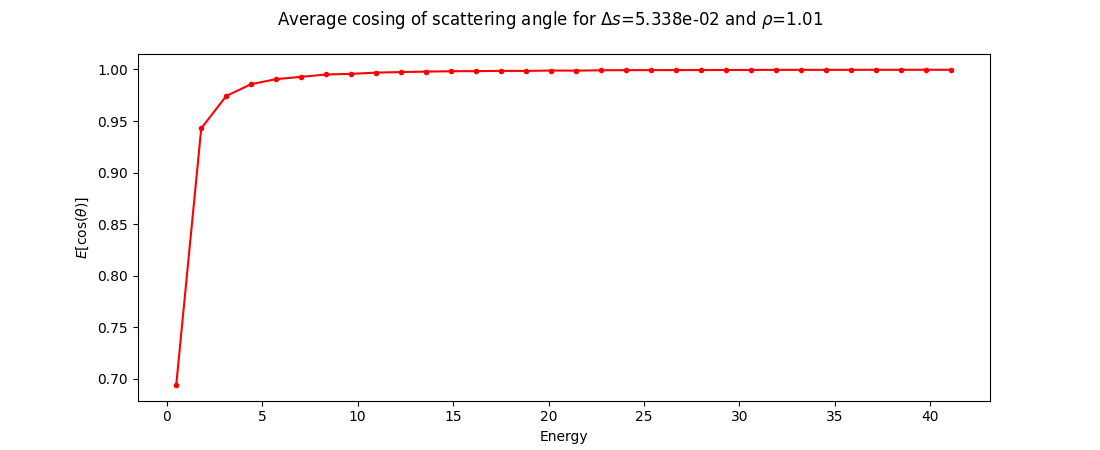

In [16]:
# Plot cos(theta)
stepsizeIndex = stepsizeArray.size//2
densityIndex = densityArray.size//2

# Data
fig, ax1 = plt.subplots(figsize=(11, 4.5))
fig.suptitle(f'Average cosine of scattering angle for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 0], '.-r', label=f'$\cos(\\theta)$')
ax1.set_xlabel('Energy')
ax1.set_ylabel('$E[\cos(\\theta)]$')

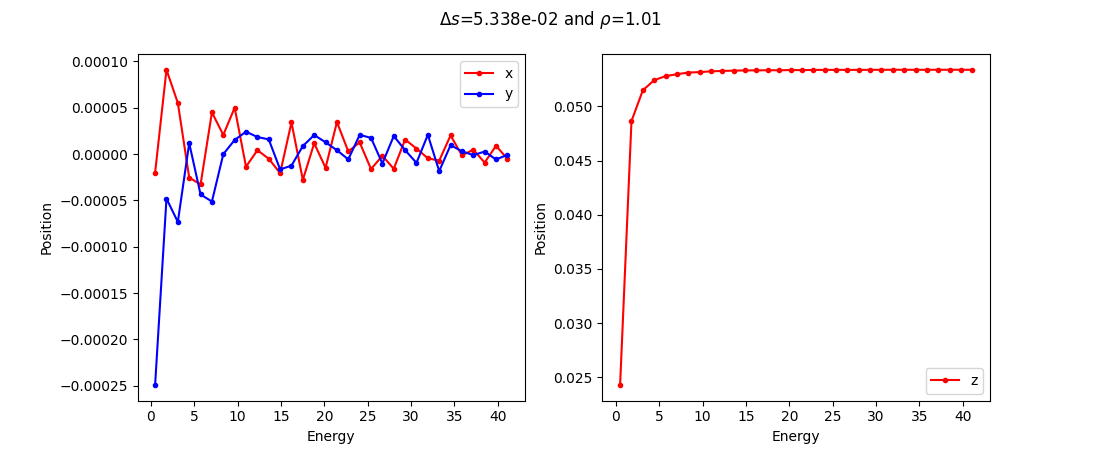

In [12]:
# Average x, y and z position
stepsizeIndex = stepsizeArray.size//2
densityIndex = densityArray.size//2

# Data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle(f'Mean position for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 1], '.-r', label=f'x')
ax1.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 2], '.-b', label=f'y')
ax1.set_xlabel('Energy')
ax1.set_ylabel('Position')
ax1.legend()

ax2.plot(energies, bigLUT[:, stepsizeIndex, densityIndex, 3], '.-r', label=f'z')
ax2.set_xlabel('Energy')
ax2.set_ylabel('Position')
ax2.legend()

# Left: should be zero, some minor noise on the result
# Right: high energy lots of forward scattering. Low energy, less forward scattering.

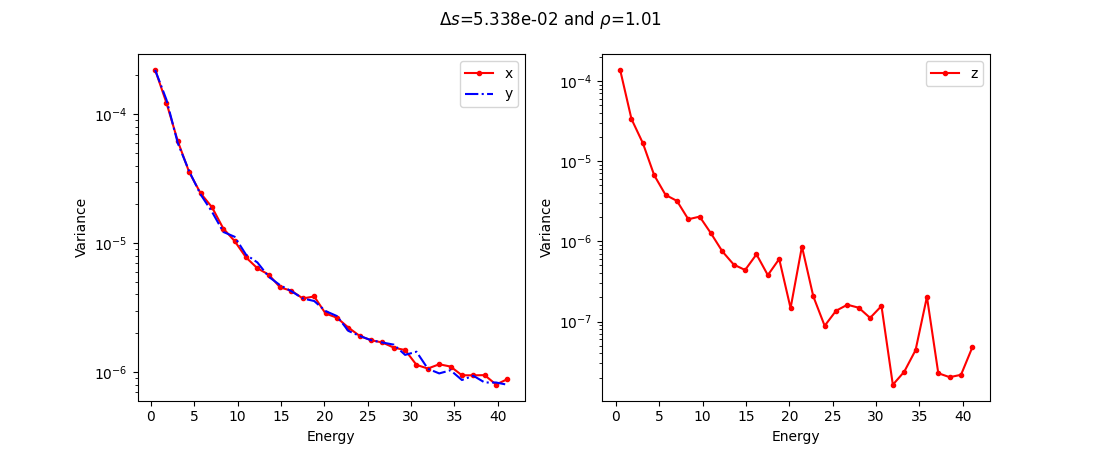

In [15]:
# Average x, y and z position
stepsizeIndex = stepsizeArray.size//2
densityIndex = densityArray.size//2

# Data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle(f'Variance on position for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.semilogy(energies, bigLUT[:, stepsizeIndex, densityIndex, 4], '.-r', label=f'x')
ax1.semilogy(energies, bigLUT[:, stepsizeIndex, densityIndex, 5], '-.b', label=f'y')
ax1.set_xlabel('Energy')
ax1.set_ylabel('Variance')
ax1.legend()

ax2.semilogy(energies, bigLUT[:, stepsizeIndex, densityIndex, 6], '.-r', label=f'z')
ax2.set_xlabel('Energy')
ax2.set_ylabel('Variance')
ax2.legend()

# Little noise on variance

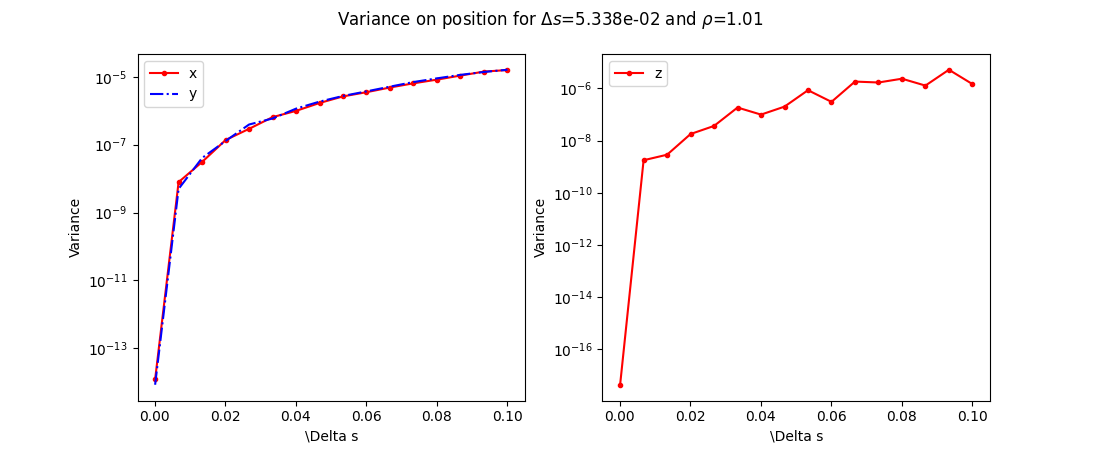

In [18]:
# Average x, y and z position
energyIndex = energies.size//2
densityIndex = densityArray.size//2

# Data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle(f'Variance on position for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.semilogy(stepsizeArray, bigLUT[energyIndex, :, densityIndex, 4], '.-r', label=f'x')
ax1.semilogy(stepsizeArray, bigLUT[energyIndex, :, densityIndex, 5], '-.b', label=f'y')
ax1.set_xlabel('\Delta s')
ax1.set_ylabel('Variance')
ax1.legend()

ax2.semilogy(stepsizeArray, bigLUT[energyIndex, :, densityIndex, 6], '.-r', label=f'z')
ax2.set_xlabel('\Delta s')
ax2.set_ylabel('Variance')
ax2.legend()

) missing from current font.st-packages/ipympl/backend_nbagg.py:336: UserWarning: Glyph 13 (
  self.figure.savefig(buf, format='png', dpi='figure')


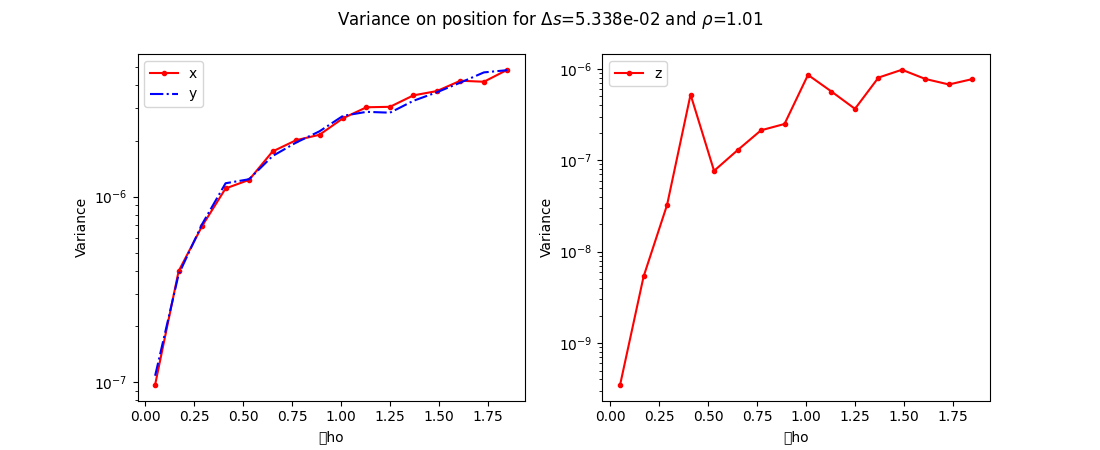

In [19]:
# Average x, y and z position
energyIndex = energies.size//2
stepsizeIndex = stepsizeArray.size//2

# Data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))
fig.suptitle(f'Variance on position for $\Delta s$={stepsizeArray[stepsizeIndex]:.3e} and $\\rho$={densityArray[densityIndex]}')

ax1.semilogy(densityArray, bigLUT[energyIndex, stepsizeIndex, :, 4], '.-r', label=f'x')
ax1.semilogy(densityArray, bigLUT[energyIndex, stepsizeIndex, :, 5], '-.b', label=f'y')
ax1.set_xlabel('\rho')
ax1.set_ylabel('Variance')
ax1.legend()

ax2.semilogy(densityArray, bigLUT[energyIndex, stepsizeIndex, :, 6], '.-r', label=f'z')
ax2.set_xlabel('\rho')
ax2.set_ylabel('Variance')
ax2.legend()